# Importy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing, datasets, neighbors
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV


# Wczytanie oraz pierwsze spojrzenie na dane

In [ ]:
df = pd.read_csv("/content/australia_rain_tomorrow_raw.csv")

In [ ]:
df.info

<bound method DataFrame.info of               Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       01/12/2008   Albury     13.4     22.9       0.6          NaN   
1       02/12/2008   Albury      7.4     25.1       0.0          NaN   
2       03/12/2008   Albury     12.9     25.7       0.0          NaN   
3       04/12/2008   Albury      9.2     28.0       0.0          NaN   
4       05/12/2008   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
142188  20/06/2017    Uluru      3.5     21.8       0.0          NaN   
142189  21/06/2017    Uluru      2.8     23.4       0.0          NaN   
142190  22/06/2017    Uluru      3.6     25.3       0.0          NaN   
142191  23/06/2017    Uluru      5.4     26.9       0.0          NaN   
142192  24/06/2017    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
0            NaN           W

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Sprawdzamy jakie typy danych występują w naszym zbiorze

In [ ]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

Sprawdzamy braki danych w każdej kolumnie

In [ ]:
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

# Przygotowanie danych do modelowania

## Usuwanie rekordów, w których występują braki danych zmiennej objaśnianej

In [ ]:
df = df[df['RainTomorrow'].notna()]

## Wstępne przygotowanie zmiennych objaśniających

Liczba wartości unikalnych w kolumnach ze zmiennymi kategorialnymi

In [ ]:
df.select_dtypes('object').nunique()

Date            3436
Location          49
WindGustDir       16
WindDir9am        16
WindDir3pm        16
RainToday          2
RainTomorrow       2
dtype: int64

Wyrzucamy 4 pierwsze zmienne, ponieważ mają zbyt wiele unikalnych wartości, przez co powstałoby dużo zmiennych zero-jedynkowych

In [ ]:
df.drop(['Location', 'WindGustDir','WindDir9am', 'WindDir3pm', 'Date', 'RISK_MM'], axis = 1, inplace = True)

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].replace(to_replace = 'No', value = 0)
df['RainTomorrow'] = df['RainTomorrow'].replace(to_replace = 'Yes', value = 1)
df['RainToday'] = df['RainToday'].replace(to_replace = 'No', value = 0)
df['RainToday'] = df['RainToday'].replace(to_replace = 'Yes', value = 1)

Sprawdzamy jaka jest proporcja dni deszczowych do dni bez deszczu

In [ ]:
df['RainToday'].sum()/df['RainToday'].count()

0.2234226171450489

Tworzymy macierz korelacji aby zbadać zależność pomiędzy zmiennymi i wizualizujemy przed i po wyróżnieniu zmiennych które są skorelowane na poziomie większym niż 80%

In [ ]:
df.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
MinTemp,1.000000,0.736267,0.104255,0.467261,0.072961,0.177285,0.176005,0.175749,-0.234211,0.005999,-0.451260,-0.461623,0.077625,0.020489,0.901813,0.708865,0.056185,0.083936
MaxTemp,0.736267,1.000000,-0.074839,0.588915,0.469967,0.067690,0.014680,0.050800,-0.505432,-0.509270,-0.332293,-0.427279,-0.289865,-0.279053,0.887020,0.984562,-0.228884,-0.159237
Rainfall,0.104255,-0.074839,1.000000,-0.064549,-0.227525,0.133497,0.086816,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.011477,-0.079178,0.500997,0.239032
Evaporation,0.467261,0.588915,-0.064549,1.000000,0.366607,0.203001,0.193936,0.128895,-0.505890,-0.392785,-0.269907,-0.293160,-0.185032,-0.184287,0.545497,0.574275,-0.187975,-0.119285
Sunshine,0.072961,0.469967,-0.227525,0.366607,1.000000,-0.032831,0.008040,0.056012,-0.491603,-0.629122,0.040959,-0.020464,-0.675610,-0.704202,0.291139,0.490180,-0.330635,-0.450768
WindGustSpeed,0.177285,0.067690,0.133497,0.203001,-0.032831,1.000000,0.604837,0.686419,-0.215461,-0.026663,-0.457891,-0.412922,0.071235,0.109088,0.150258,0.032970,0.155490,0.234010
WindSpeed9am,0.176005,0.014680,0.086816,0.193936,0.008040,0.604837,1.000000,0.519971,-0.270807,-0.031607,-0.227923,-0.174916,0.024280,0.053584,0.129298,0.005108,0.102267,0.090995
WindSpeed3pm,0.175749,0.050800,0.057759,0.128895,0.056012,0.686419,0.519971,1.000000,-0.145942,0.015903,-0.295567,-0.254988,0.052780,0.025269,0.163601,0.028567,0.080074,0.087817
Humidity9am,-0.234211,-0.505432,0.223725,-0.505890,-0.491603,-0.215461,-0.270807,-0.145942,1.000000,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777,0.353358,0.257161
Humidity3pm,0.005999,-0.509270,0.255312,-0.392785,-0.629122,-0.026663,-0.031607,0.015903,0.667388,1.000000,-0.027449,0.051840,0.517037,0.523270,-0.221467,-0.557989,0.378766,0.446160


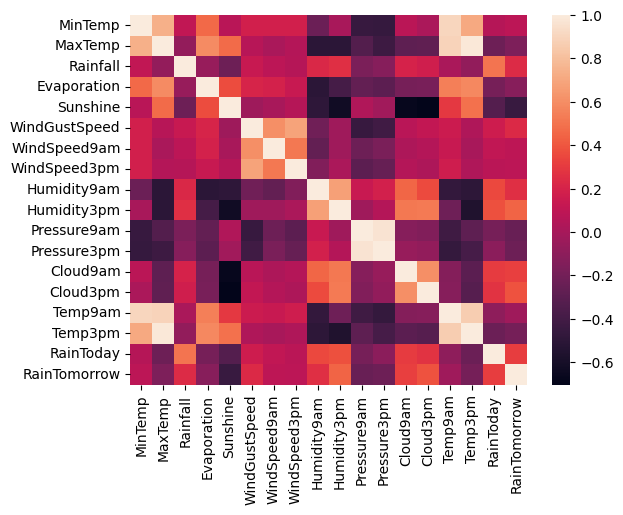

In [ ]:
sns.heatmap(df.corr());

In [ ]:
df.corr()[df.corr()>0.8]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
MinTemp,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.901813,NaN,NaN,NaN
MaxTemp,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.887020,0.984562,NaN,NaN
Rainfall,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Evaporation,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sunshine,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpeed,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindSpeed9am,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindSpeed3pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Humidity9am,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Humidity3pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


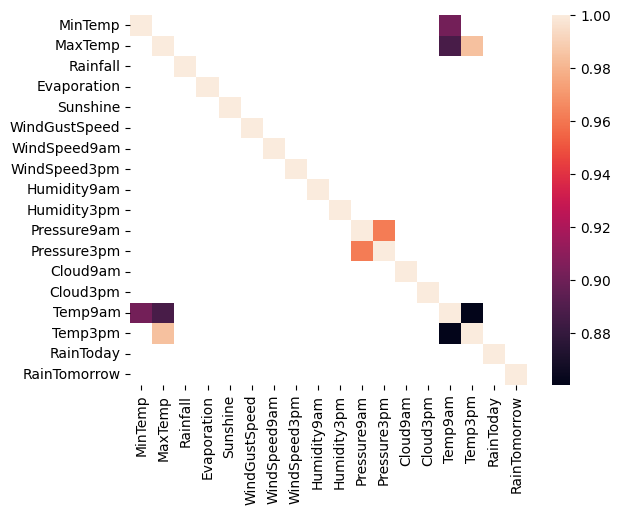

In [ ]:
sns.heatmap(df.corr()[df.corr()>0.8]);

Zatem usuwamy temp9am oraz temp3pm, ponieważ mamy zmienne maxtemp oraz mintemp, które są z nimi ściśle powiązane

In [ ]:
df.drop(['Temp9am', 'Temp3pm'], axis=1,inplace = True)

In [ ]:
df.isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
RainToday         1406
RainTomorrow         0
dtype: int64

In [ ]:
df.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
RainToday        float64
RainTomorrow       int64
dtype: object

Jak widać pozostałe zmienne są numeryczne, zatem możemy przejść do uzupełniania braków danych

Statystyki opisowe zmiennych przed uzupełnieniem braków danych prezentują się następująco

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,140787.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,0.223423,0.224181
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,0.416541,0.417043
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,0.000000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,0.000000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,1.000000,1.000000


In [ ]:
df.skew()

MinTemp          0.023900
MaxTemp          0.224917
Rainfall         9.888061
Evaporation      3.746834
Sunshine        -0.502911
WindGustSpeed    0.874305
WindSpeed9am     0.775494
WindSpeed3pm     0.631433
Humidity9am     -0.482821
Humidity3pm      0.034515
Pressure9am     -0.096211
Pressure3pm     -0.046198
Cloud9am        -0.224286
Cloud3pm        -0.224092
RainToday        1.327992
RainTomorrow     1.322753
dtype: float64

Kurtoza

In [ ]:
df.kurtosis()

MinTemp           -0.487253
MaxTemp           -0.238446
Rainfall         180.002097
Evaporation       45.067784
Sunshine          -0.820364
WindGustSpeed      1.417855
WindSpeed9am       1.226555
WindSpeed3pm       0.775865
Humidity9am       -0.039246
Humidity3pm       -0.511101
Pressure9am        0.236200
Pressure3pm        0.132521
Cloud9am          -1.541159
Cloud3pm          -1.457933
RainToday         -0.236441
RainTomorrow      -0.250329
dtype: float64

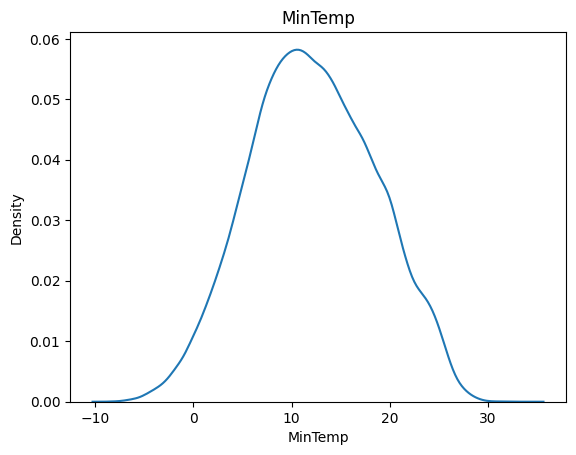

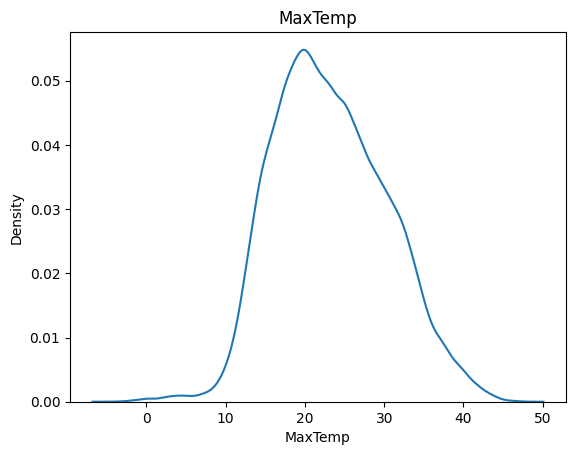

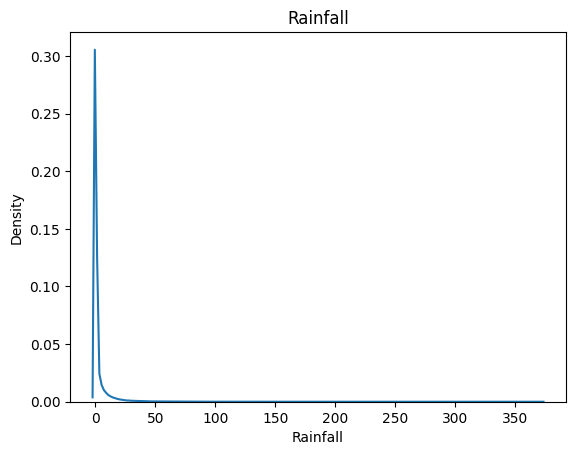

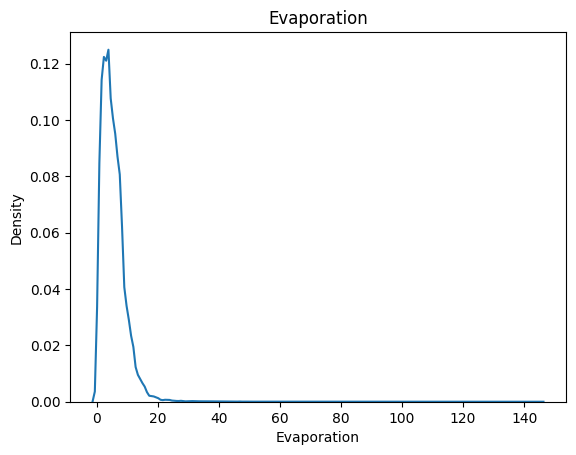

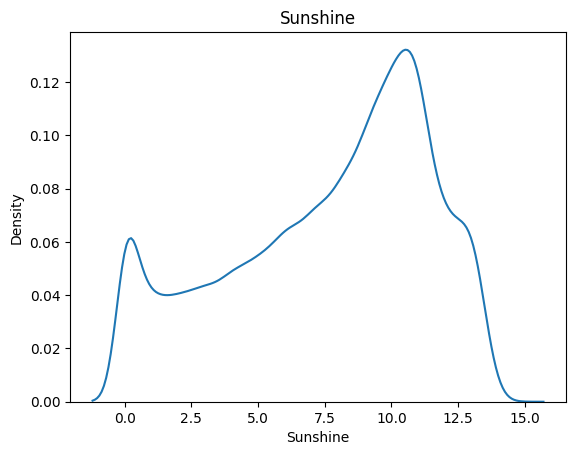

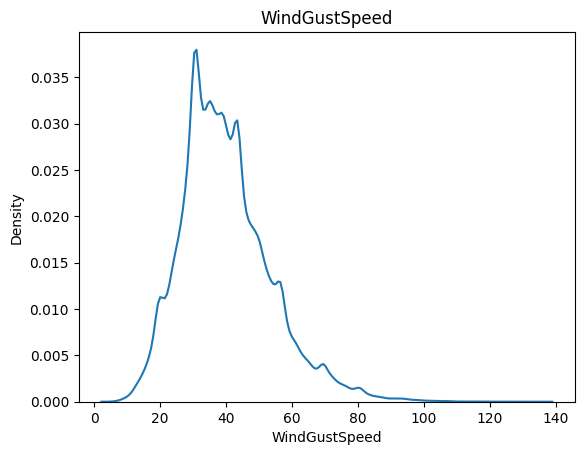

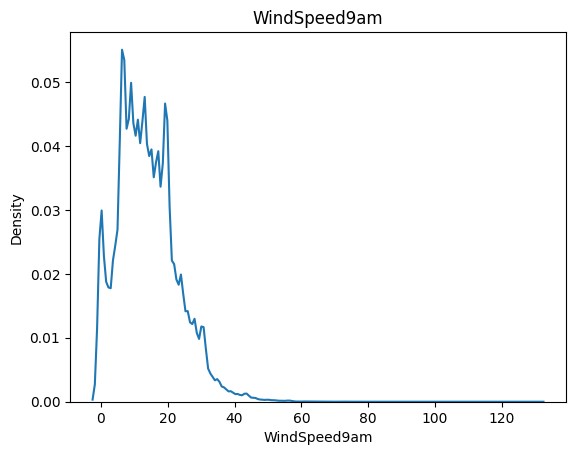

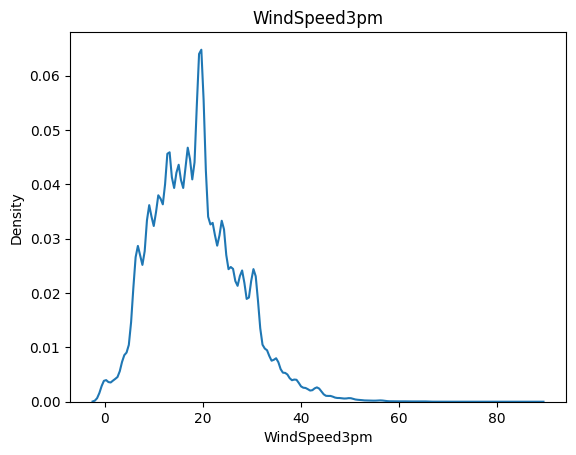

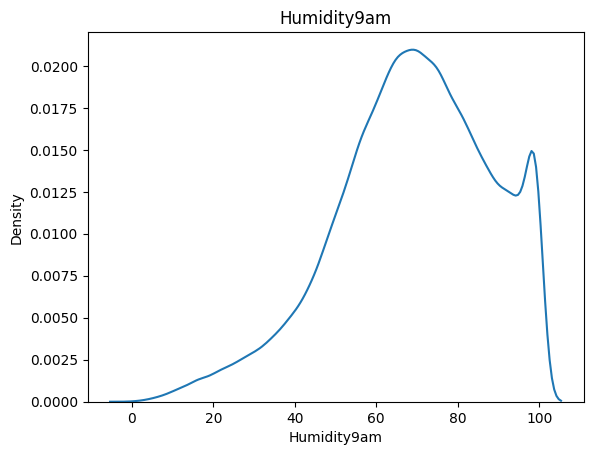

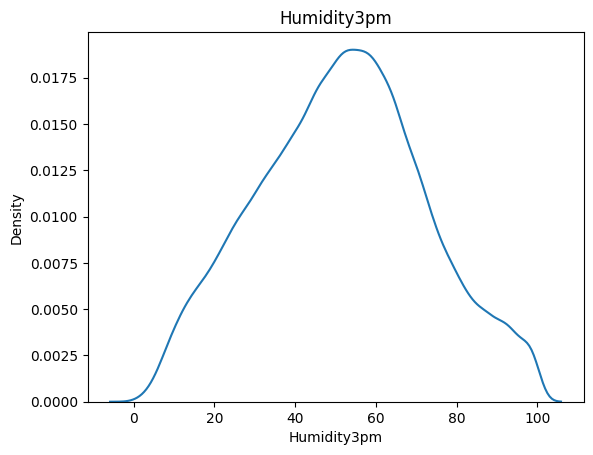

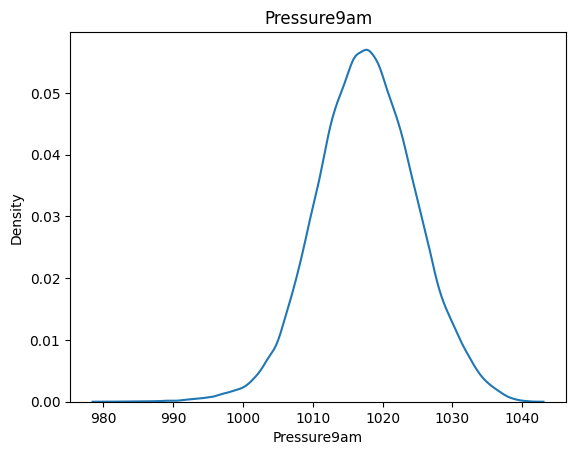

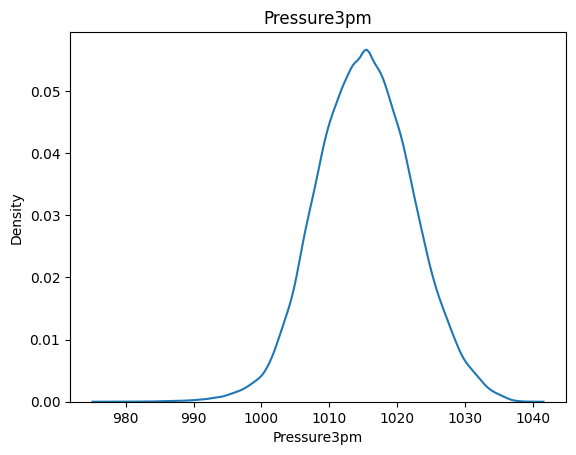

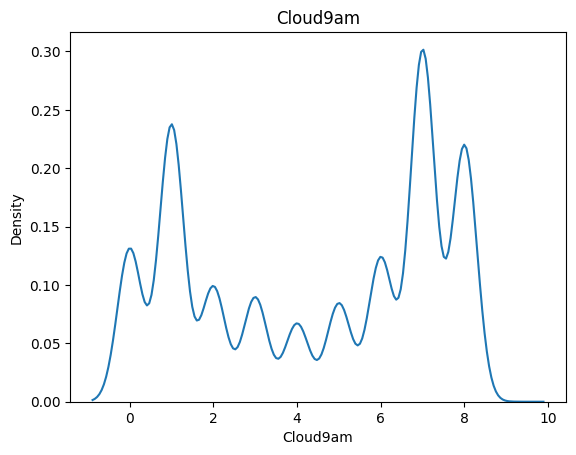

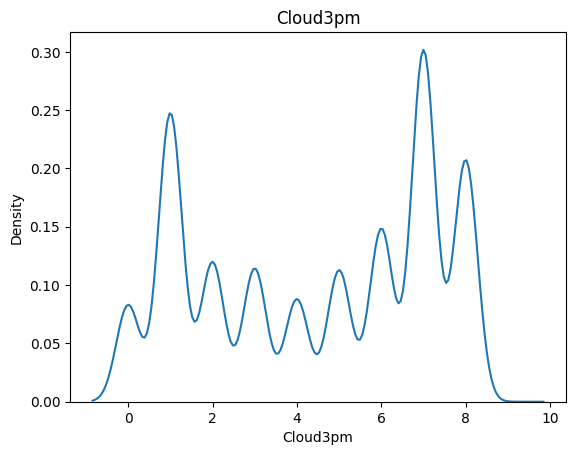

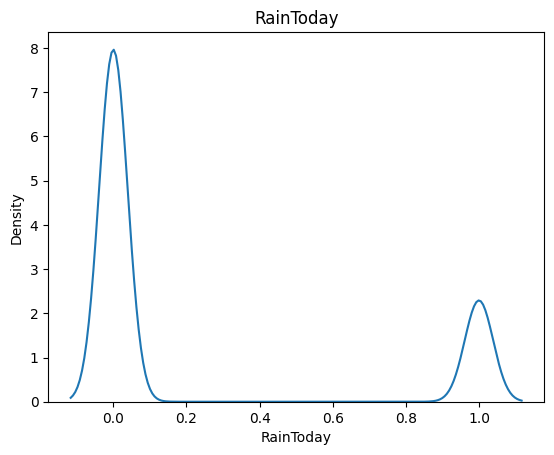

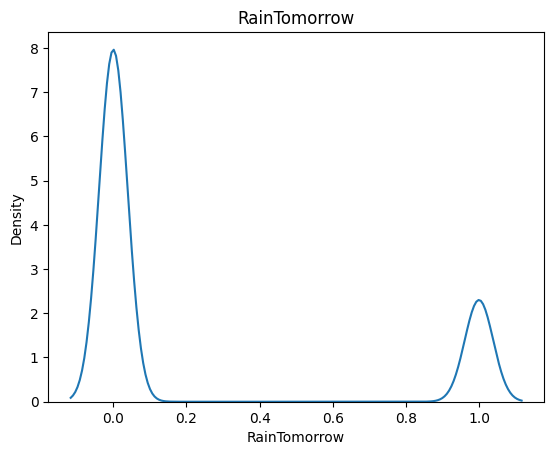

In [ ]:
for i in df.columns:
  plt.title(i)
  sns.kdeplot(df[i])
  plt.show()

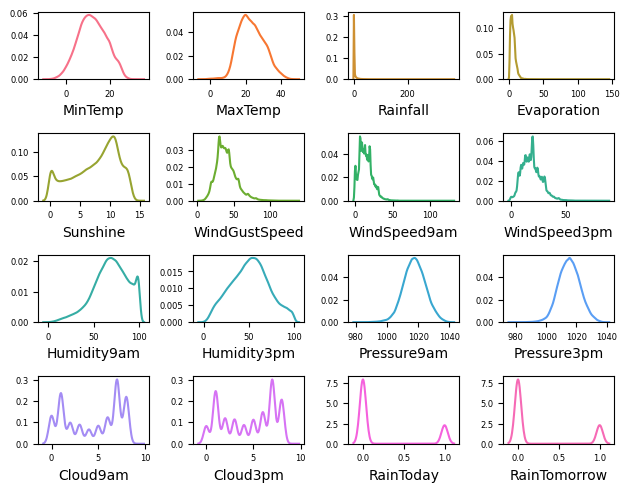

In [ ]:
figure, axis = plt.subplots(4, 4)
j = 0
k = 0
colors = sns.color_palette('husl', n_colors=len(df.columns))
for idx, i in enumerate(df.columns):
    sns.kdeplot(df[i], ax=axis[j, k], color=colors[idx])
    axis[j, k].tick_params(axis='both', labelsize=6)
    axis[j, k].set_ylabel('')
    if k == 3:
        j += 1
        k = 0
    else:
        k += 1
for ax in axis.flat:
    ax.tick_params(axis='both', labelsize=6)
plt.subplots_adjust(left=0, bottom=0, right=0.9, top=0.9, wspace=0.4, hspace=0.8)
plt.show()

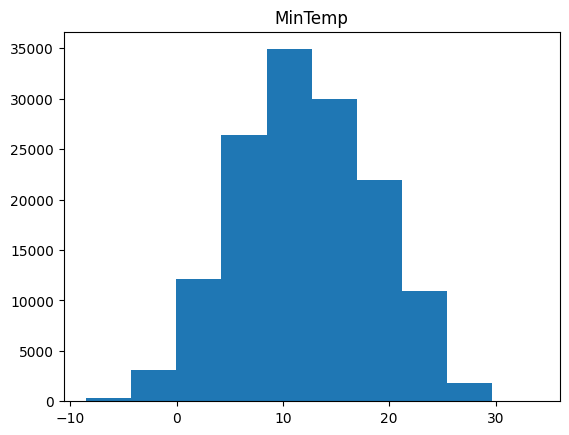

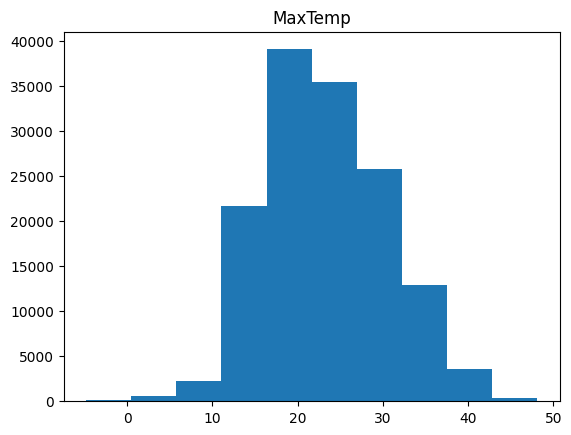

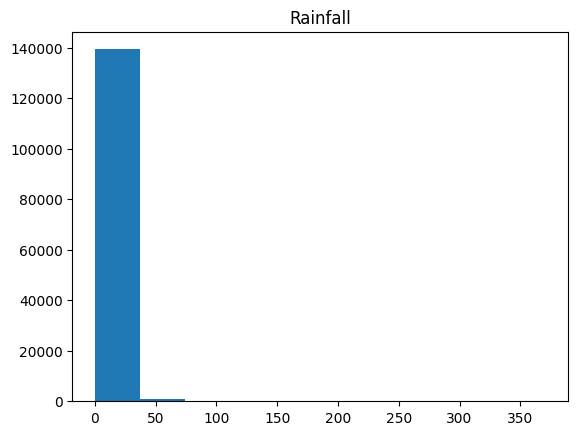

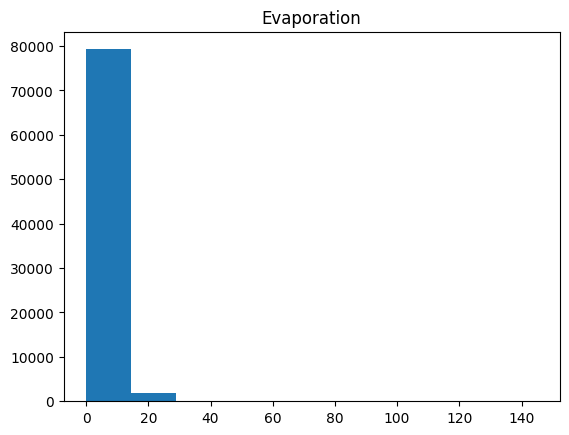

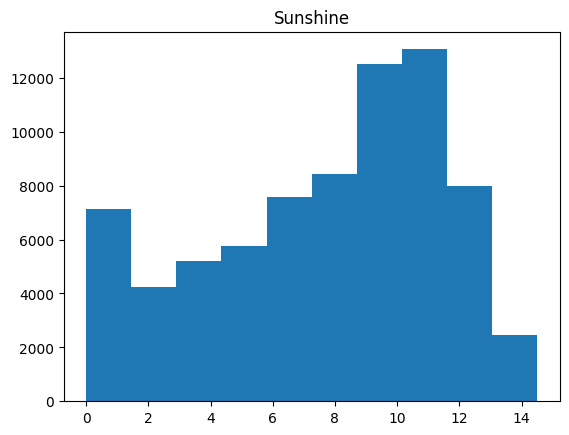

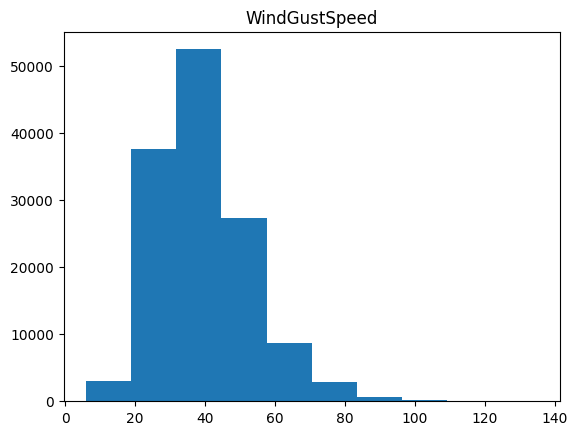

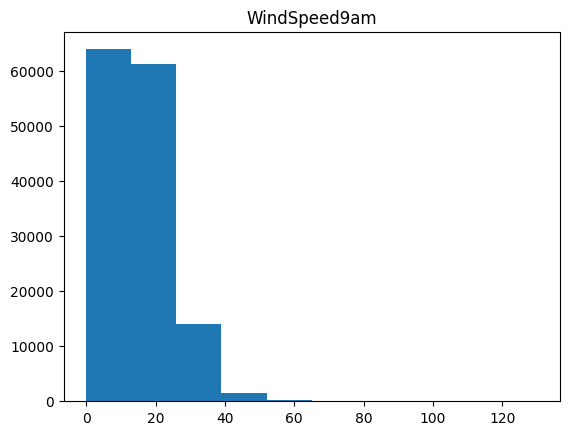

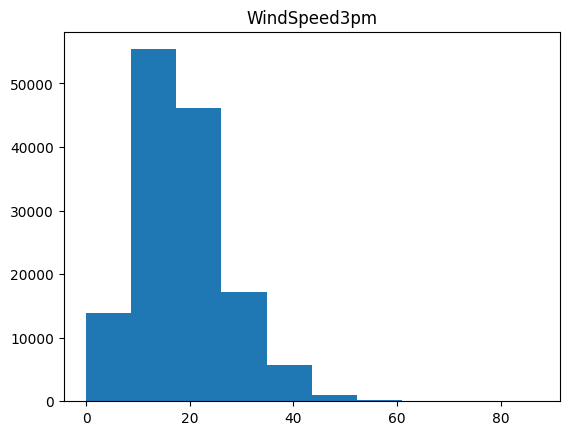

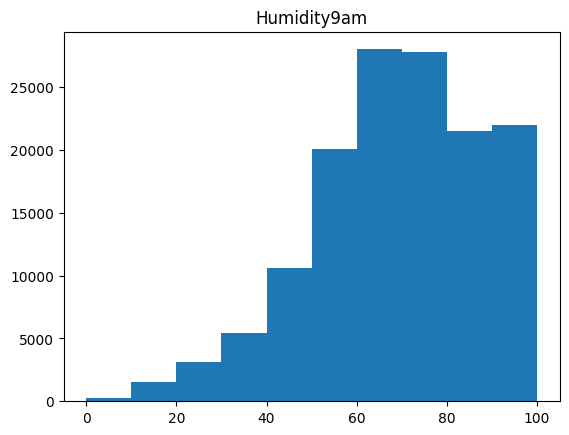

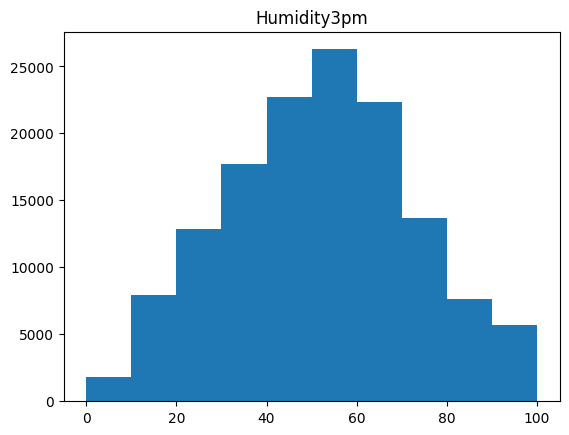

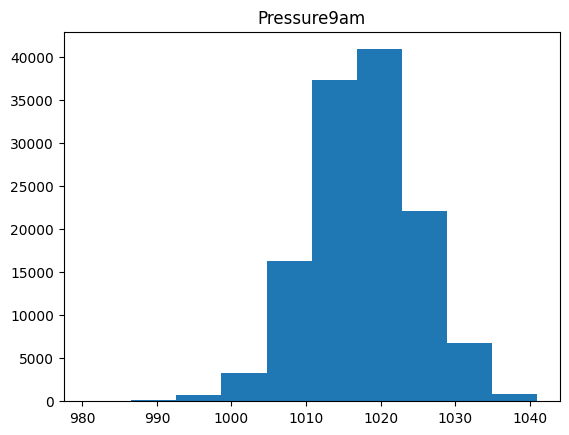

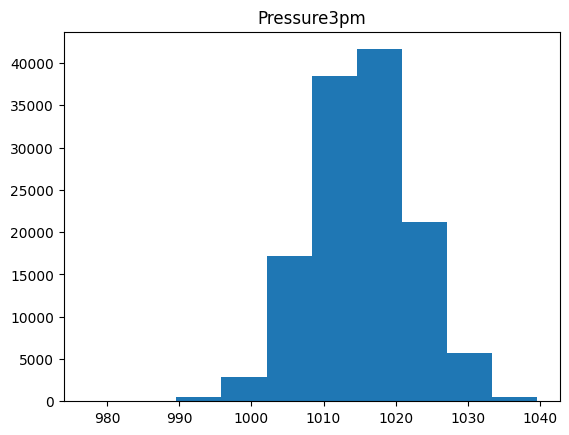

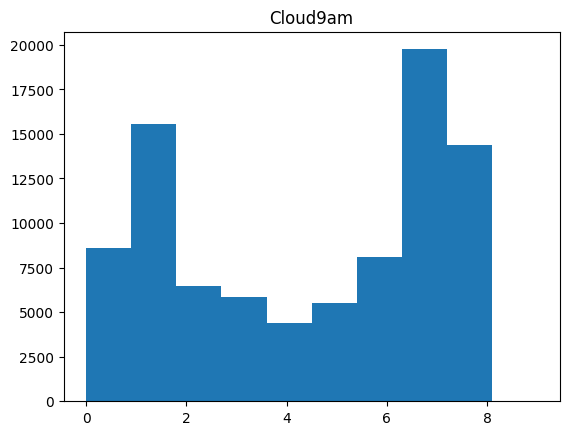

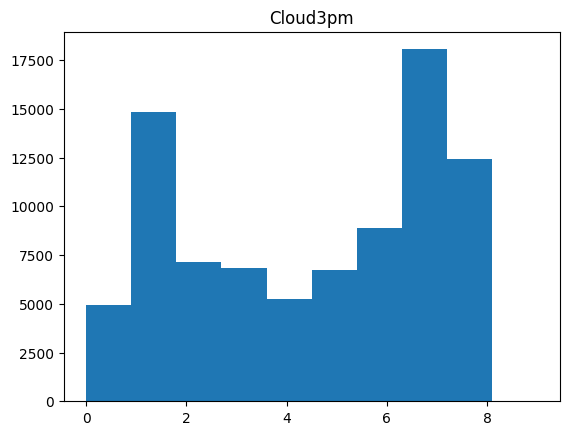

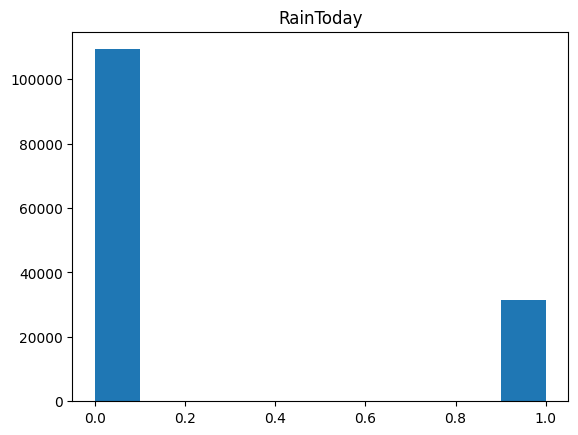

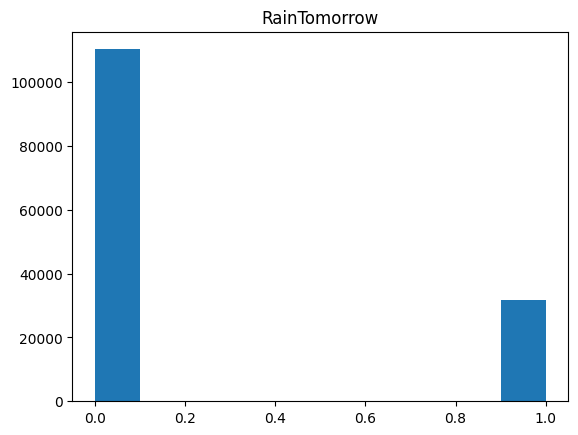

In [ ]:
for i in df.columns:
  plt.title(i)
  plt.hist(df[i])
  plt.show()

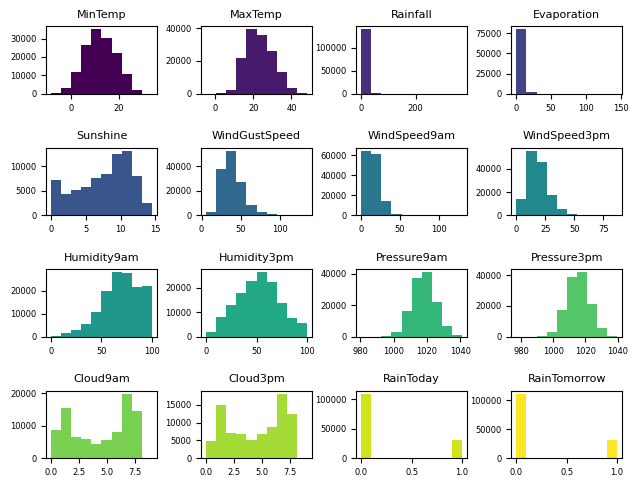

In [ ]:
figure, axis = plt.subplots(4, 4)
j = 0
k = 0
colors = plt.cm.viridis(np.linspace(0, 1, len(df.columns)))
for i, col in enumerate(df.columns):
    axis[j, k].hist(df[col], color=colors[i])
    axis[j, k].set_title(col, fontsize=8)
    axis[j, k].tick_params(axis='both', labelsize=6)
    if k == 3:
        j += 1
        k = 0
    else:
        k += 1
plt.subplots_adjust(left=0, bottom=0, right=0.9, top=0.9, wspace=0.4, hspace=0.8)
plt.show()

## Uzupełnianie braków danych

Uzupełniamy braki danych za pomocą średniej oraz w przypadku zmiennych binarnych wartością najczęściej występującą

In [ ]:
df_with_NaN = df

In [ ]:
df['RainToday'].fillna(df['RainToday'].mode().max(),inplace = True)

In [ ]:
imputer = SimpleImputer(strategy = 'mean')
df_imp = pd.DataFrame(imputer.fit_transform(df))

In [ ]:
df_imp.columns = df.columns

In [ ]:
df_imp.isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
RainTomorrow     0
dtype: int64

##Box ploty

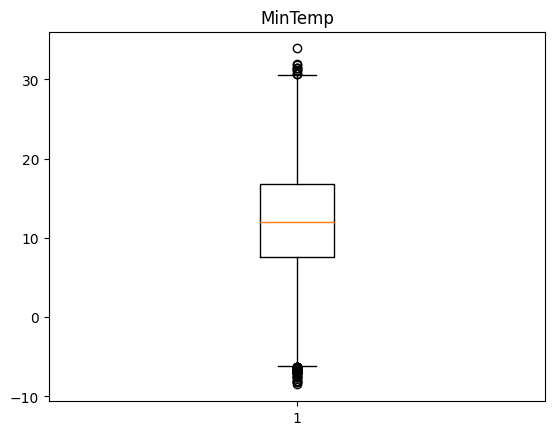

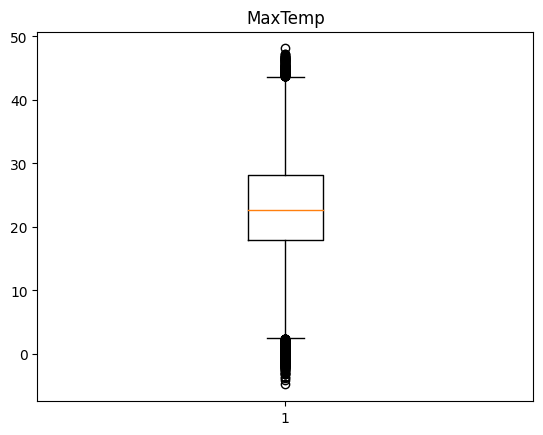

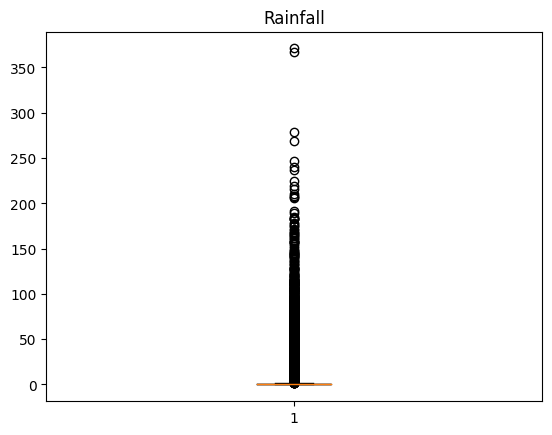

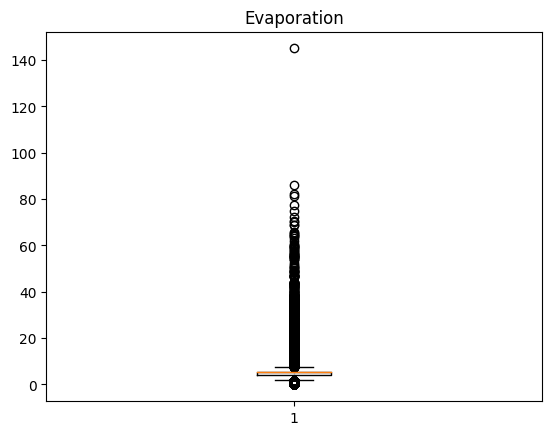

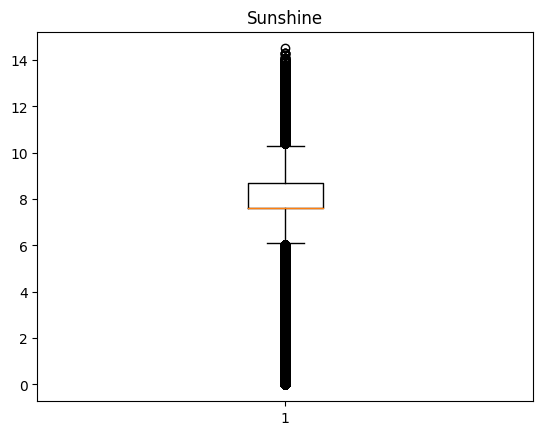

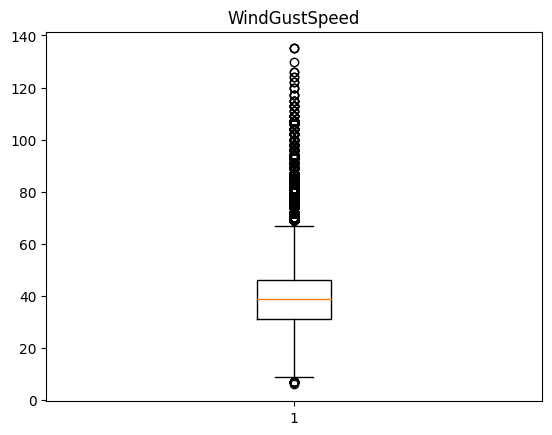

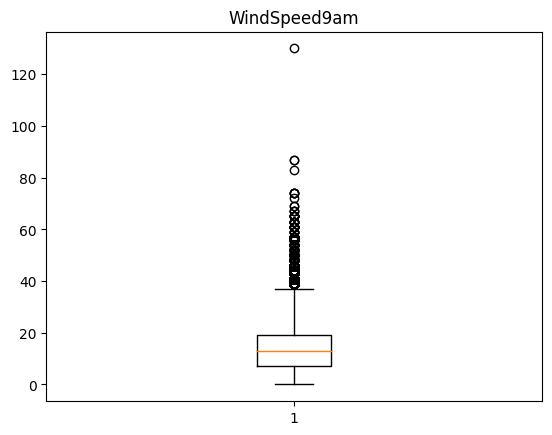

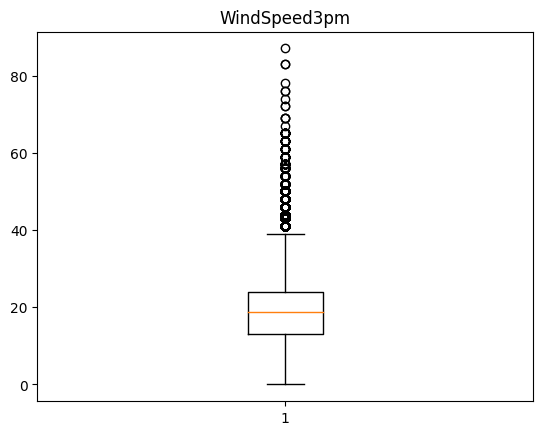

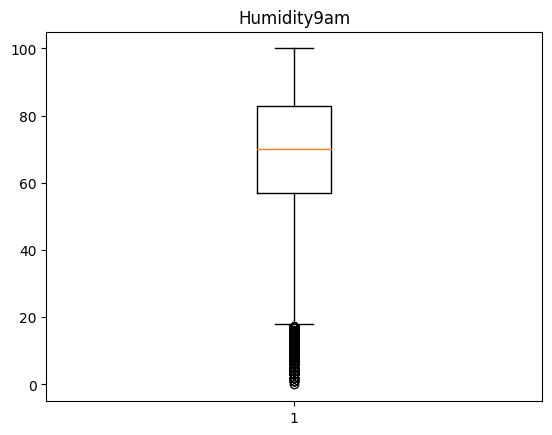

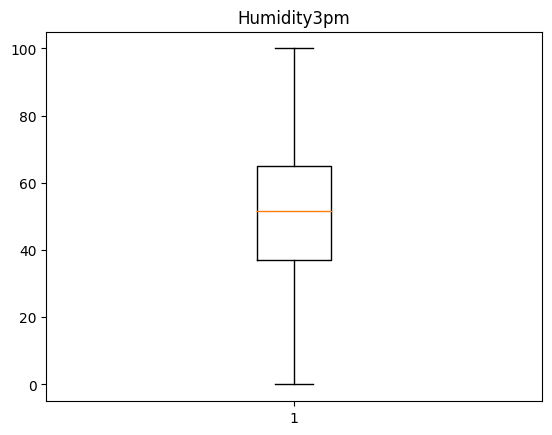

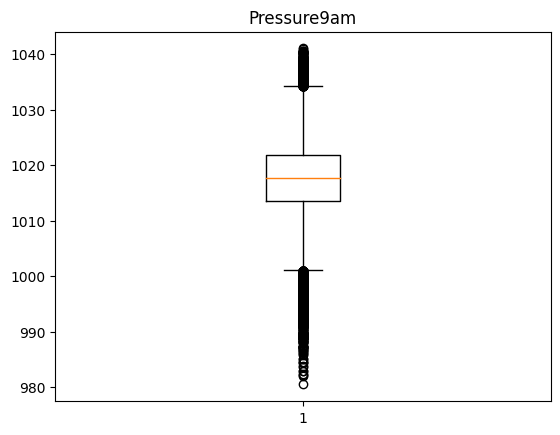

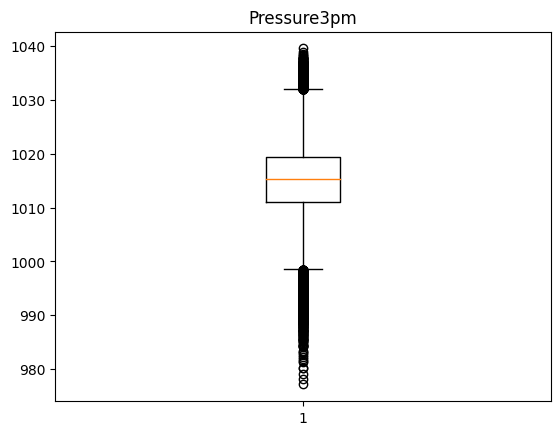

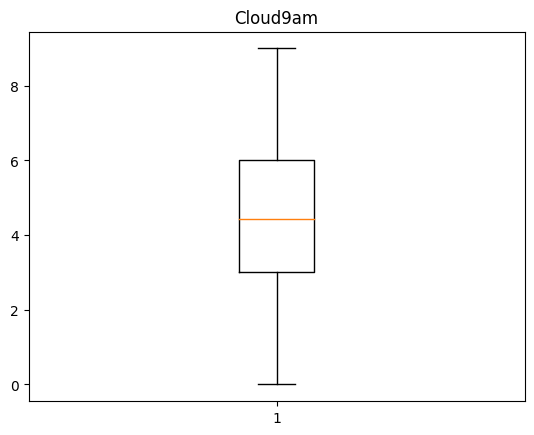

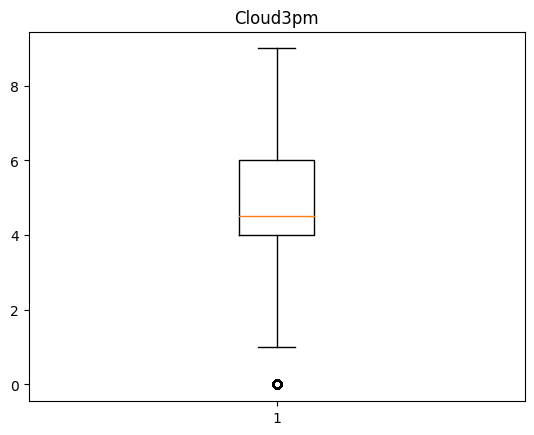

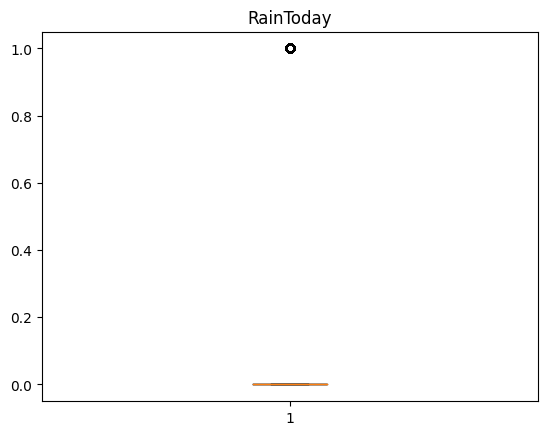

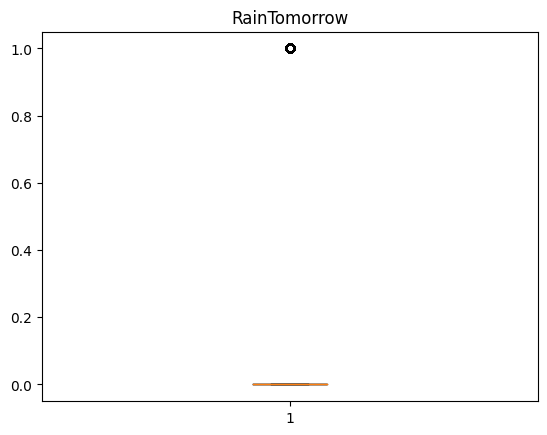

In [ ]:
for i in df_imp.columns:
  plt.title(i)
  plt.boxplot(df_imp[i])
  plt.show()

## Violin ploty

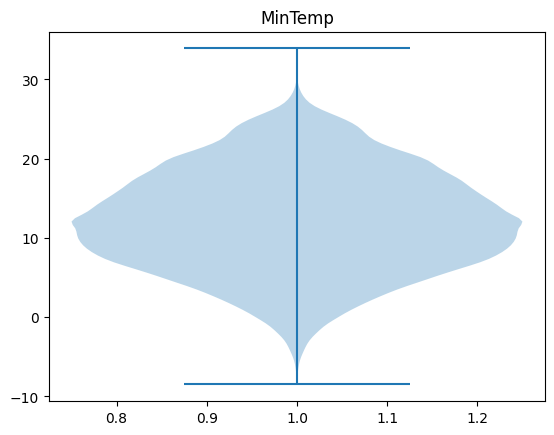

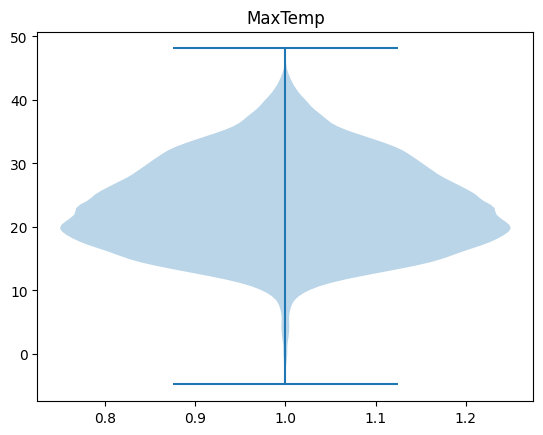

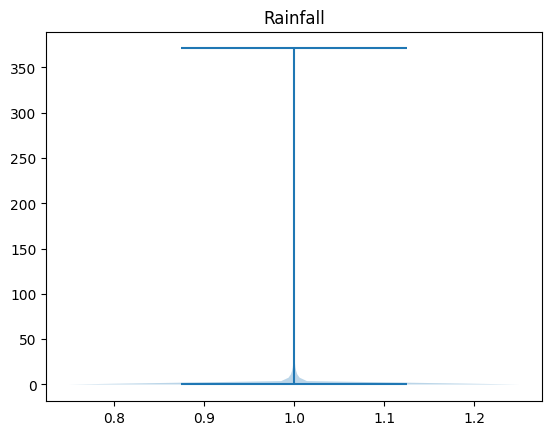

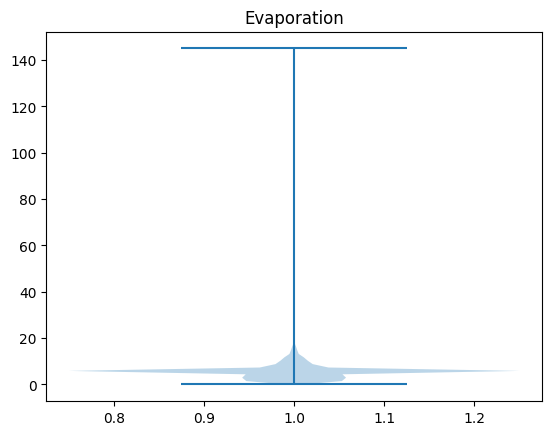

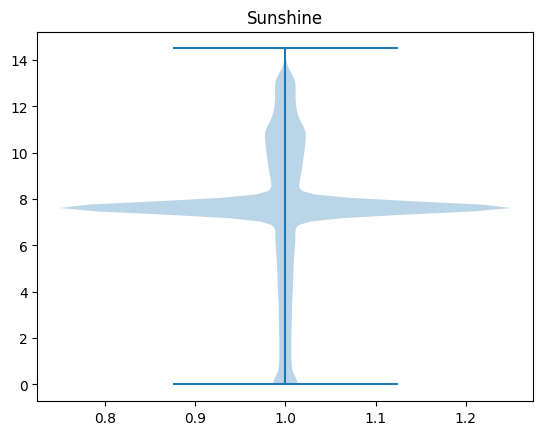

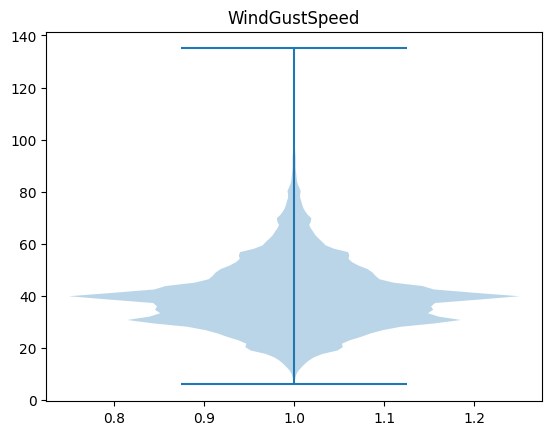

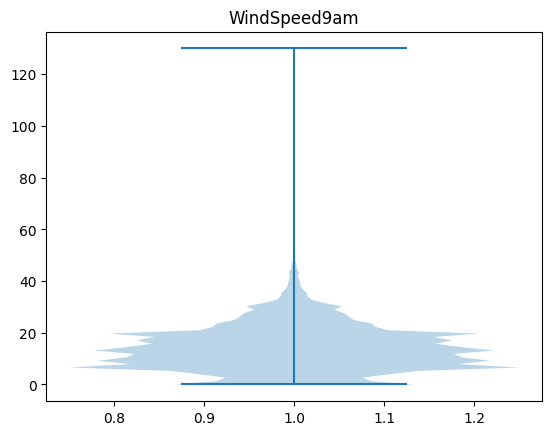

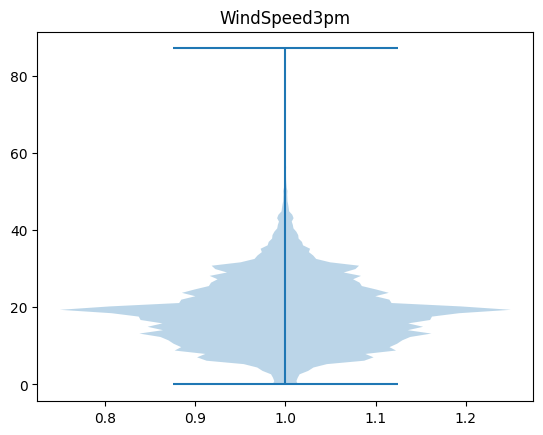

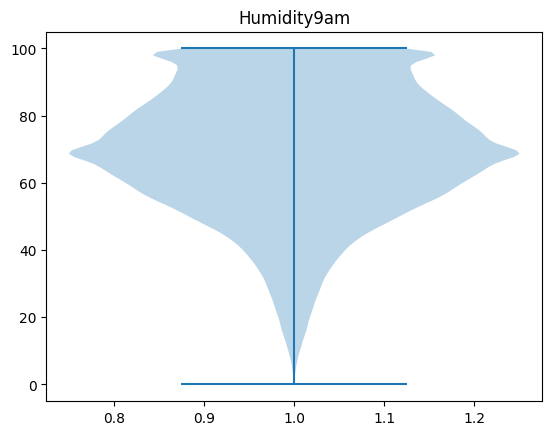

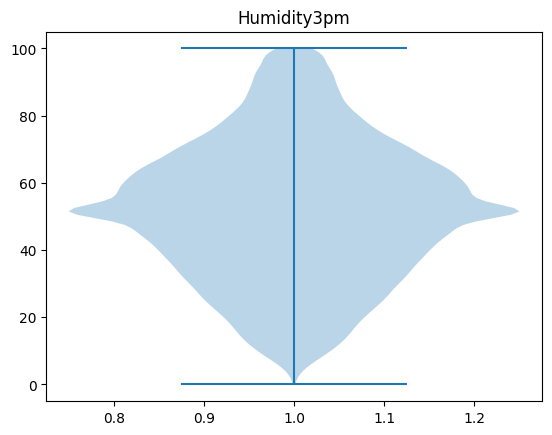

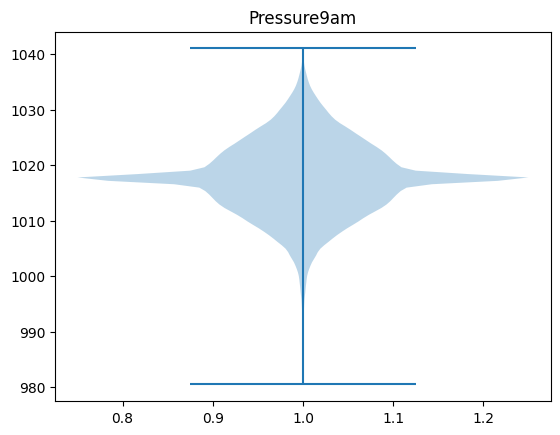

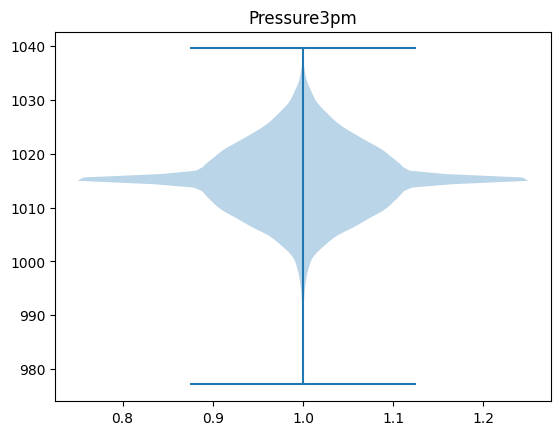

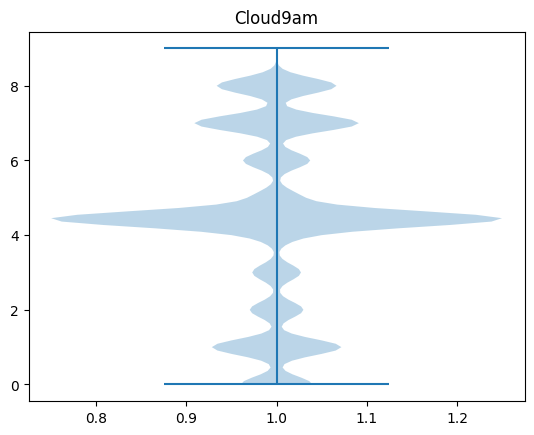

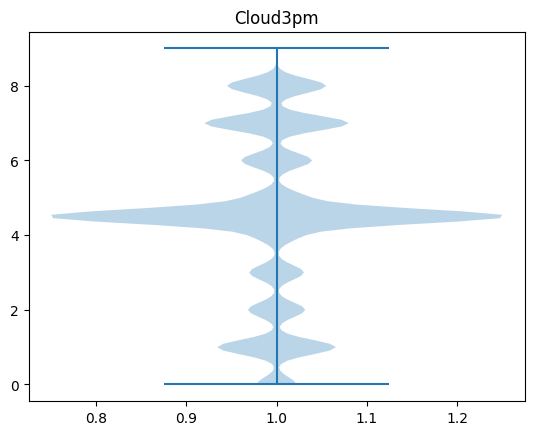

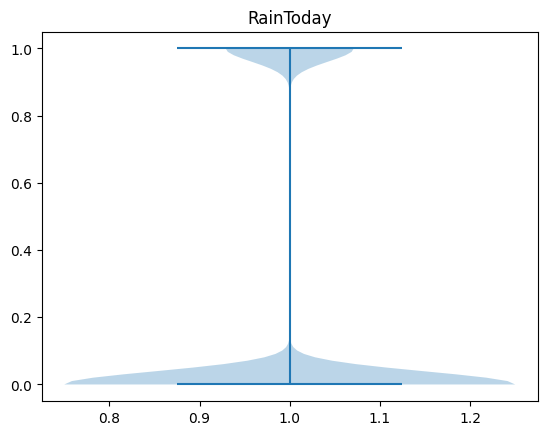

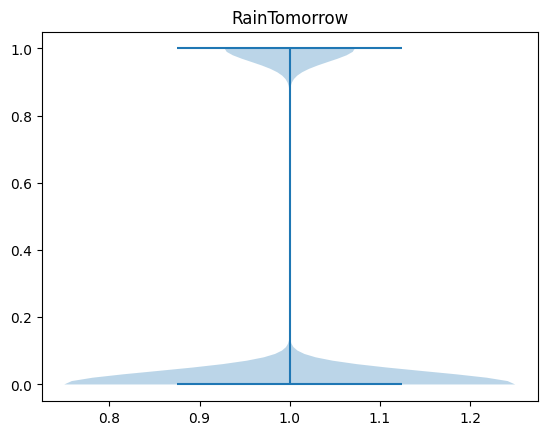

In [ ]:
for i in df_imp.columns:
  plt.title(i)
  plt.violinplot(df_imp[i])
  plt.show()

In [ ]:
Y = df_imp['RainTomorrow']
X = df_imp.drop('RainTomorrow', axis='columns')
X = X.drop('RainToday', axis="columns")
RainToday = df_imp['RainToday']

## Skalowanie zmiennych

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

In [ ]:
X_scaled_copy = X_scaled.copy()

In [ ]:
X_scaled.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm
count,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05
mean,1.663012e-16,-2.238670e-16,7.255688e-17,-1.103344e-16,-4.707073e-16,-1.874886e-16,1.599050e-18,1.679002e-17,1.471126e-16,-7.643458e-16,-1.490794e-14,-1.865771e-14,-1.471126e-16,-4.349415e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.237865e+00,-3.942143e+00,-2.789887e-01,-1.726530e+00,-2.787964e+00,-2.586651e+00,-1.581958e+00,-2.136964e+00,-3.636371e+00,-2.507433e+00,-5.507341e+00,-5.710798e+00,-1.947782e+00,-2.139575e+00
25%,-7.178699e-01,-7.492457e-01,-2.789887e-01,-4.639446e-01,-6.495101e-16,-6.838225e-01,-7.910912e-01,-6.463983e-01,-6.255971e-01,-7.053678e-01,-6.157160e-01,-6.372873e-01,-6.308796e-01,-2.390681e-01
50%,-2.917555e-02,-7.409551e-02,-2.789887e-01,0.000000e+00,-6.495101e-16,-7.491751e-02,-1.132055e-01,0.000000e+00,6.107062e-02,-6.921323e-16,0.000000e+00,-1.701449e-14,0.000000e+00,-4.219974e-16
75%,7.221273e-01,6.995141e-01,-1.840128e-01,0.000000e+00,3.931185e-01,4.578744e-01,5.646801e-01,6.148497e-01,7.477383e-01,6.583576e-01,6.146018e-01,6.198657e-01,6.860233e-01,7.111855e-01
max,3.398644e+00,3.498574e+00,4.376610e+01,4.404218e+01,2.513840e+00,7.231942e+00,1.310556e+01,7.838361e+00,1.645688e+00,2.363014e+00,3.460638e+00,3.643019e+00,2.002926e+00,2.136566e+00


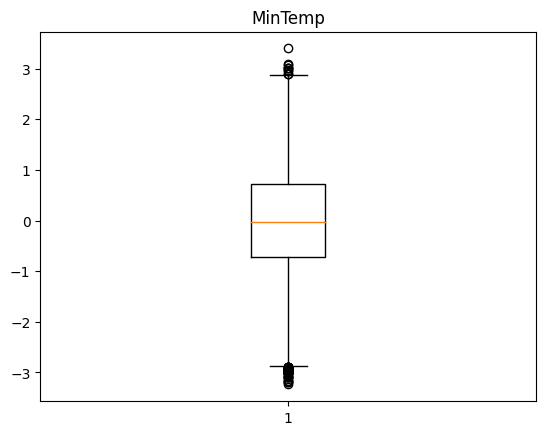

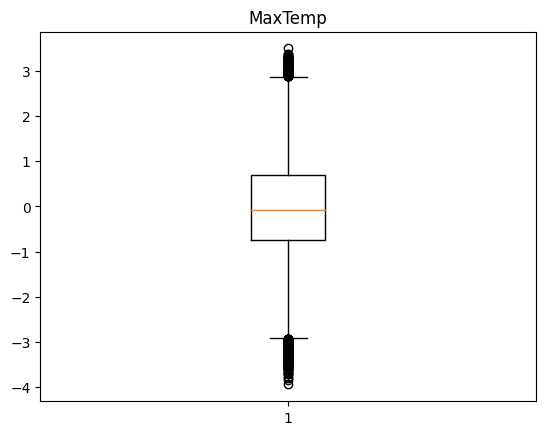

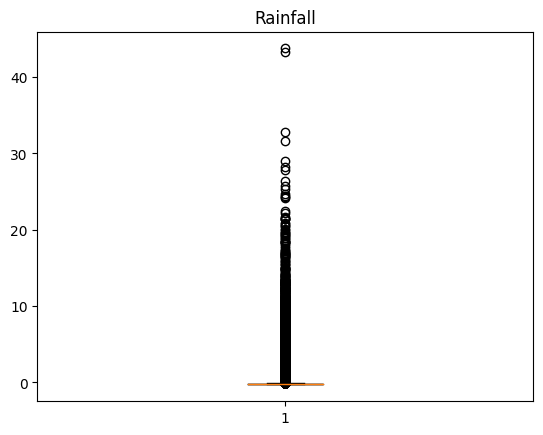

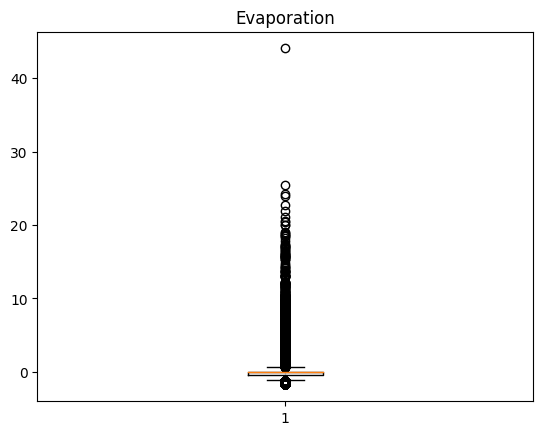

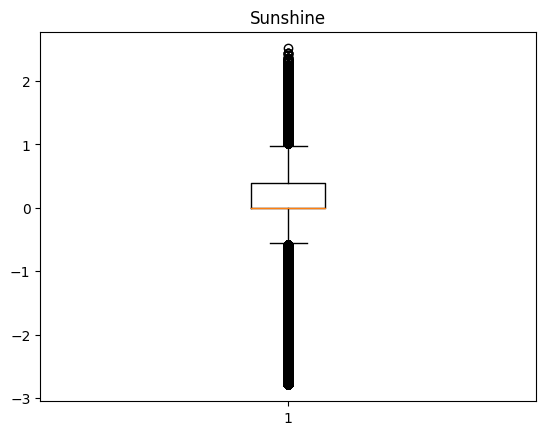

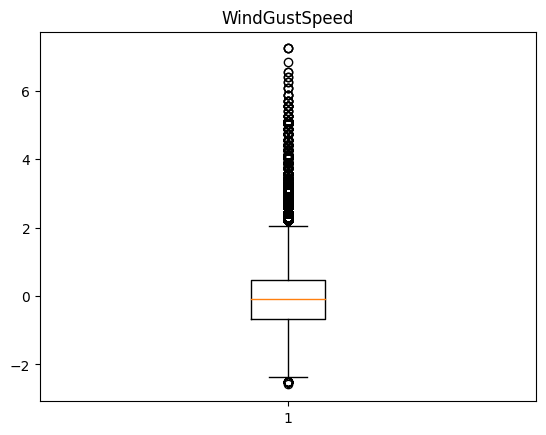

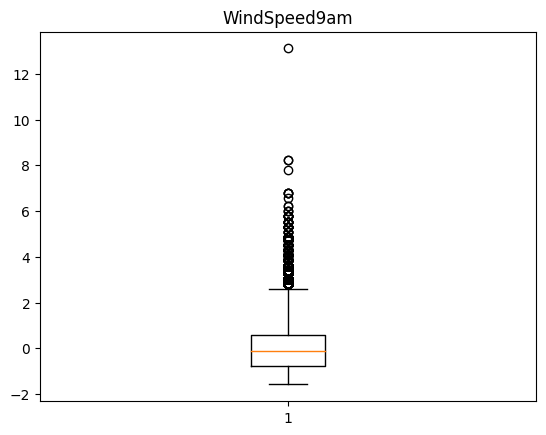

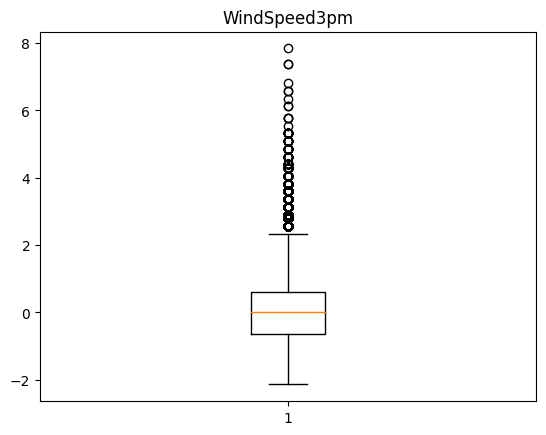

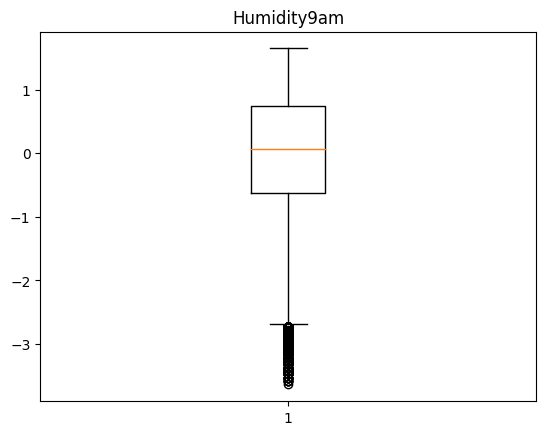

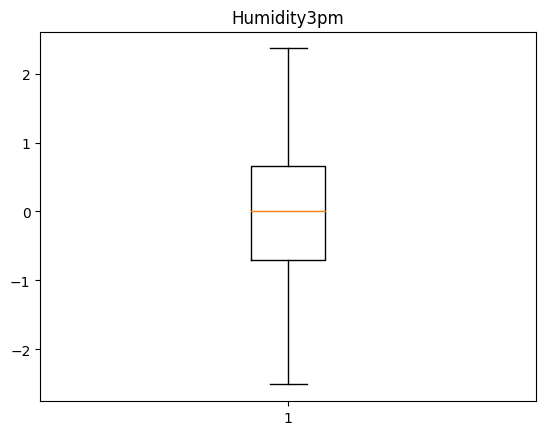

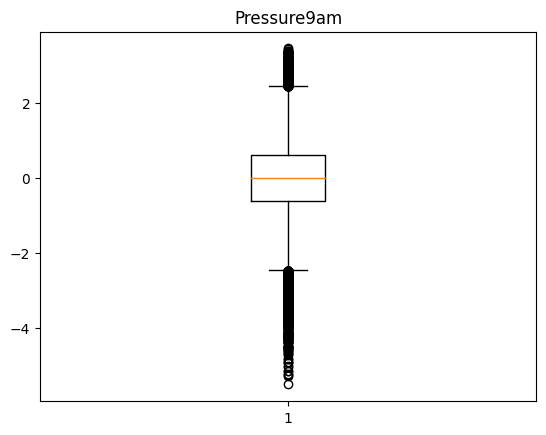

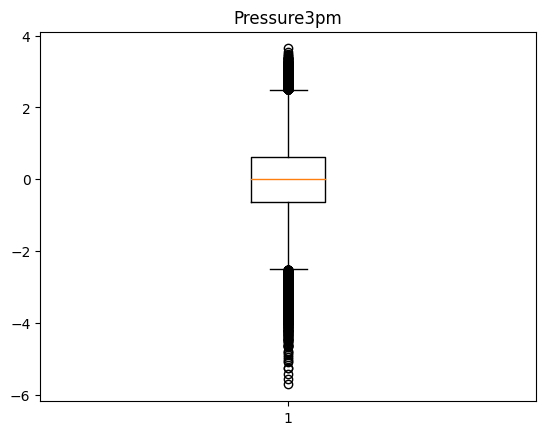

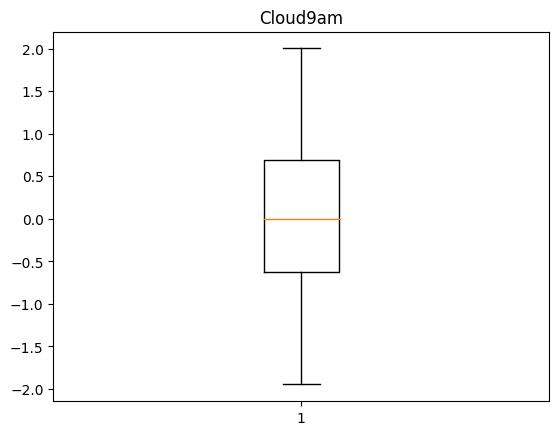

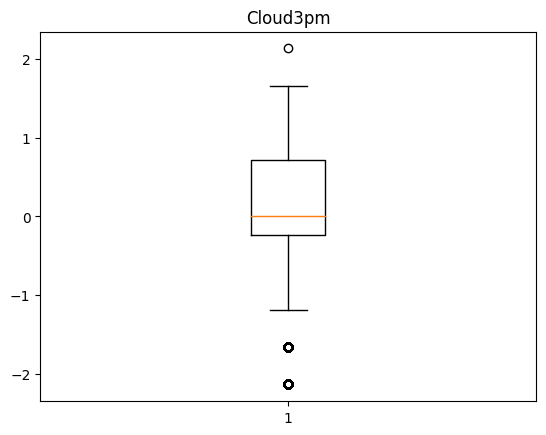

In [ ]:
for i in X_scaled.columns:
  plt.title(i)
  plt.boxplot(X_scaled[i])
  plt.show()

## Obserwacje odstające

In [ ]:
def replace_outliers(df):
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Zamiana obserwacji odstających dla wszystkich kolumn
df_final = replace_outliers(X_scaled_copy)
df_final['RainToday'] = RainToday

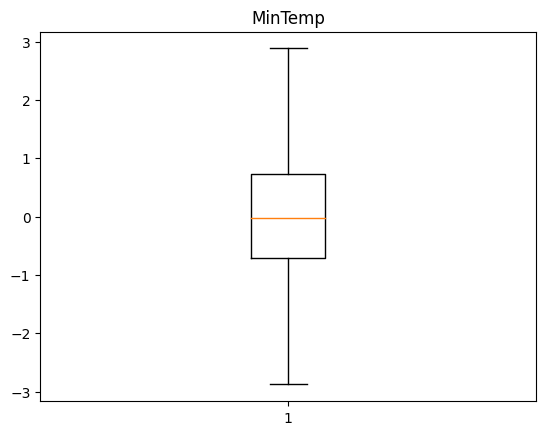

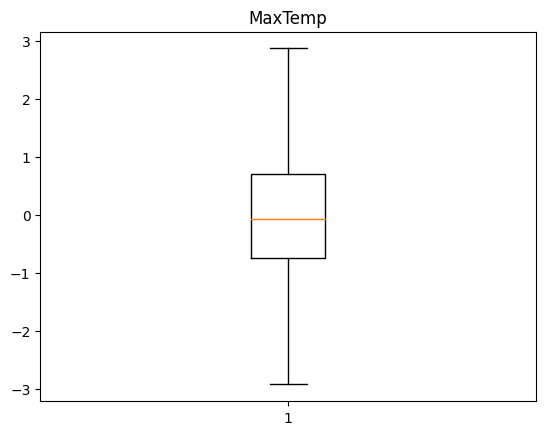

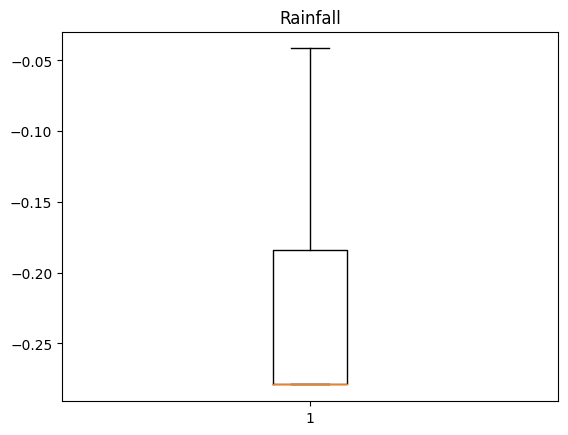

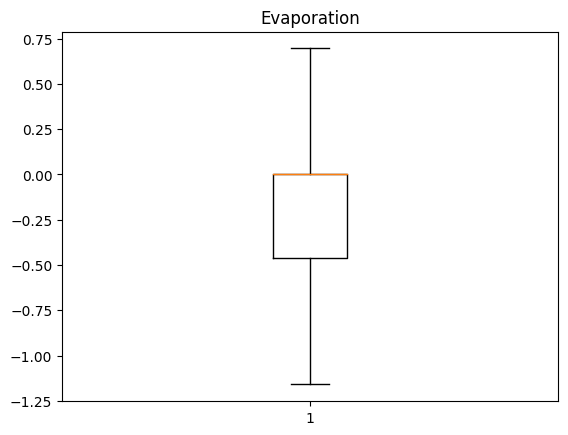

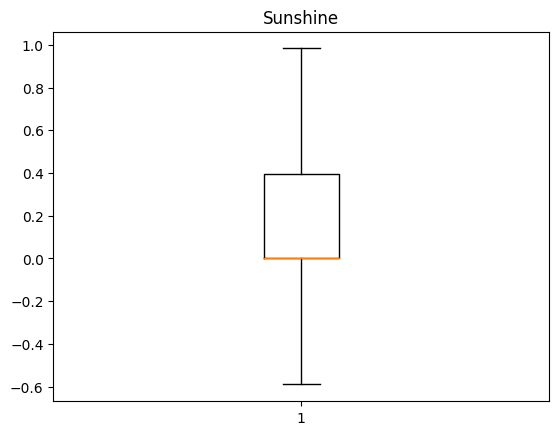

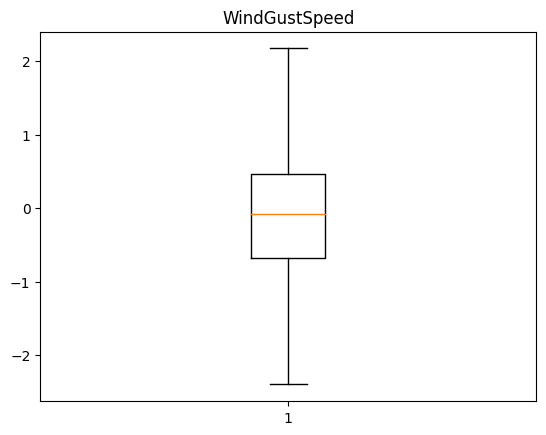

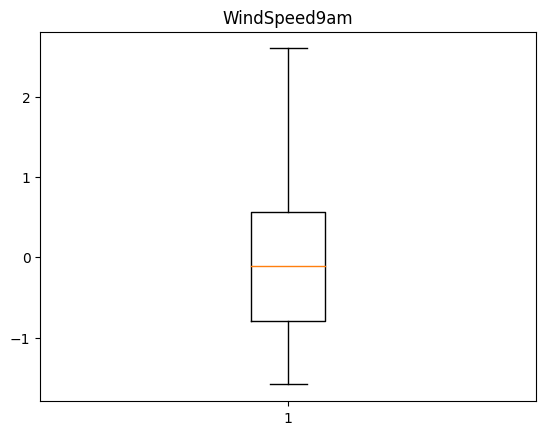

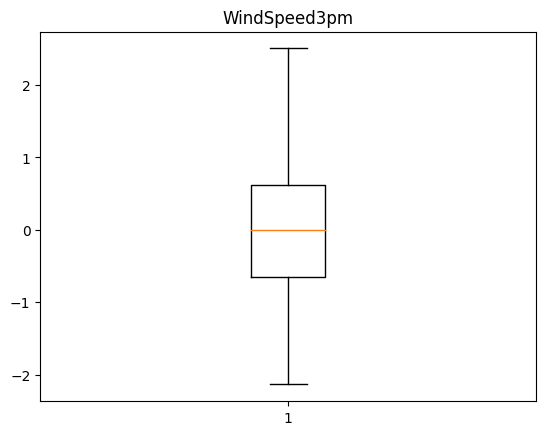

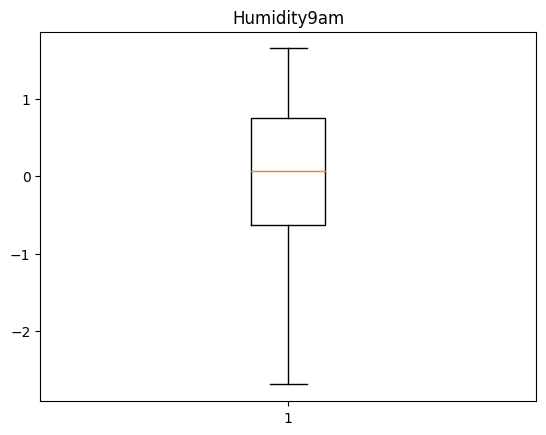

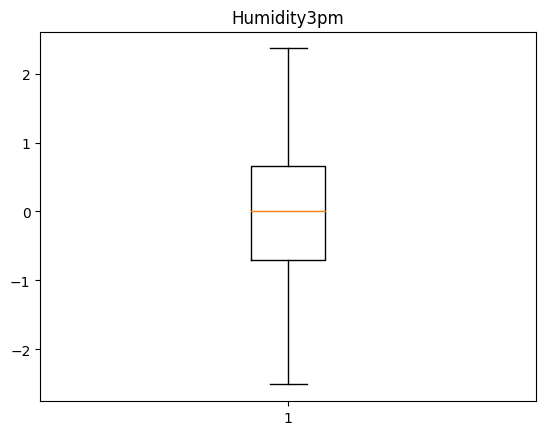

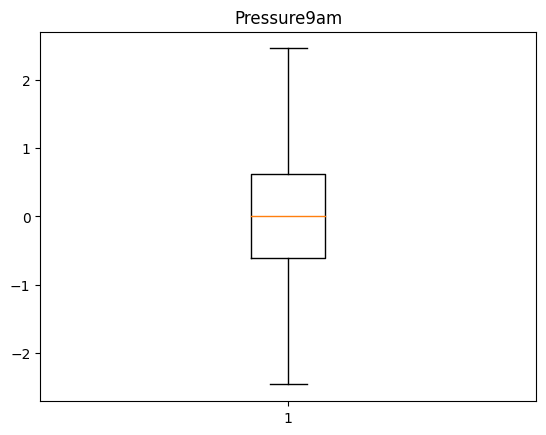

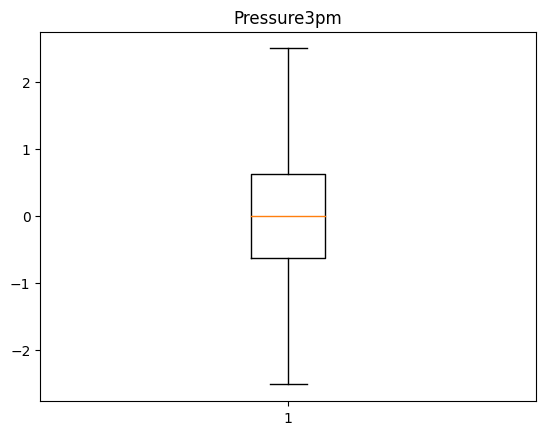

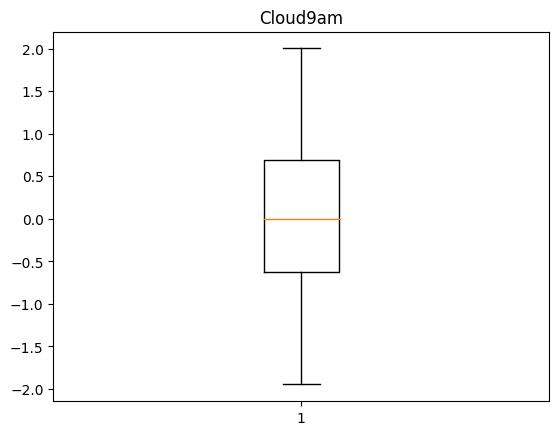

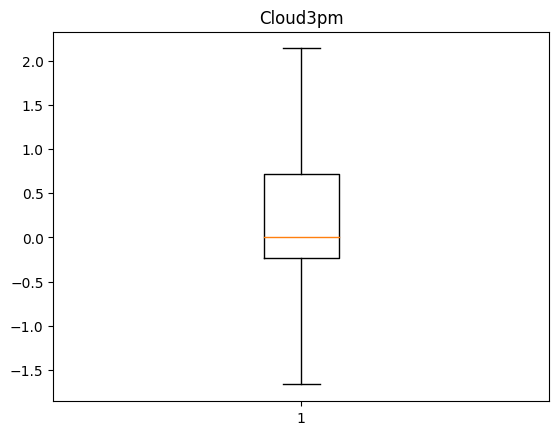

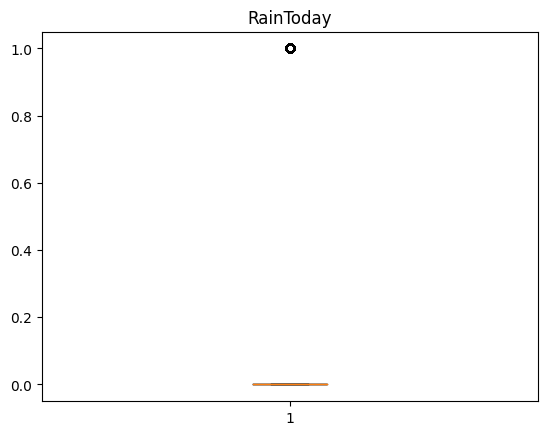

In [ ]:
for i in df_final.columns:
  plt.title(i)
  plt.boxplot(df_final[i])
  plt.show()

## Podział zbioru na uczący i testowy

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_final, Y, test_size=0.2, random_state = 1)

# Uczenie modeli

## Random Forest Classifier

In [ ]:
Forest = RandomForestClassifier()

In [ ]:
param_grid = {
    'n_estimators': [100,200],
}
CV_rf = GridSearchCV(Forest, param_grid, cv= 5, scoring = 'roc_auc')
CV_rf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 200]}, scoring='roc_auc')

In [ ]:
CV_rf.best_params_

{'n_estimators': 200}

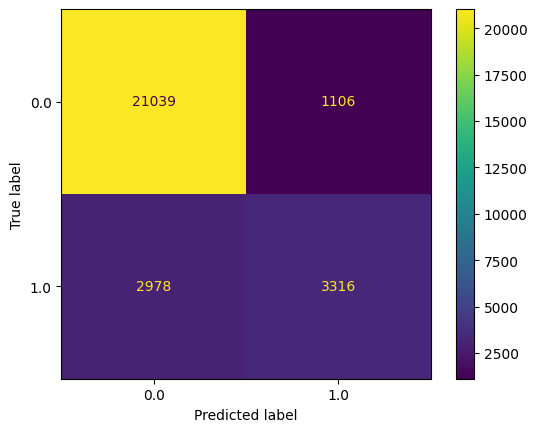

In [ ]:
Y_pred_f = CV_rf.predict(X_test)
accuracy_forest = accuracy_score(Y_test,Y_pred_f)
cm = confusion_matrix(Y_test,Y_pred_f)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CV_rf.classes_).plot()
plt.show()

In [ ]:
accuracy_forest

0.8563943879883259

In [ ]:
#cross_val_score(Forest, X_train, Y_train, cv=5)

In [ ]:
roc_auc_score(Y_test, Y_pred_f)

0.7384537076636831

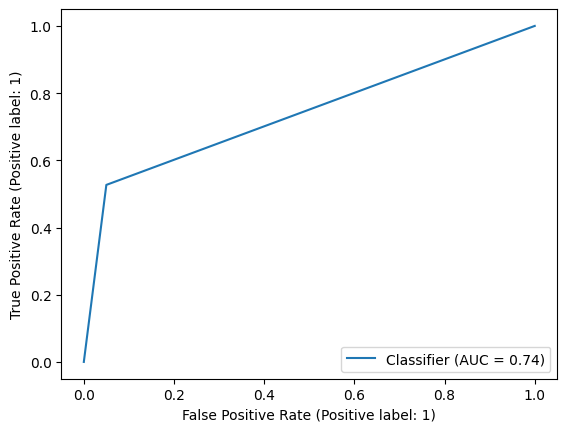

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_f)
plt.show()

## Gradient Boost Classifier

In [ ]:
parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators":[100]
    }
gs_gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, scoring = 'roc_auc')
gs_gb.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'loss': ['log_loss'], 'n_estimators': [100]},
             scoring='roc_auc')

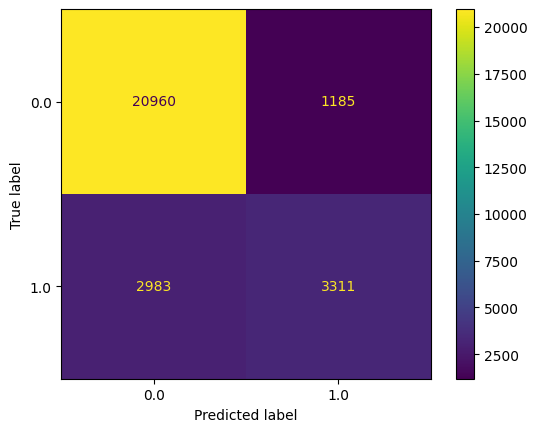

In [ ]:
Y_pred_g = gs_gb.predict(X_test)
accuracy_gradient = accuracy_score(Y_test,Y_pred_g)
cm = confusion_matrix(Y_test,Y_pred_g)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_gb.classes_).plot()
plt.show()

In [ ]:
accuracy_gradient

0.8534406976335314

In [ ]:
#cross_val_score(GradientBoost, X_train, Y_train, cv=5)

In [ ]:
roc_auc_score(Y_test, Y_pred_g)

0.7362728056258606

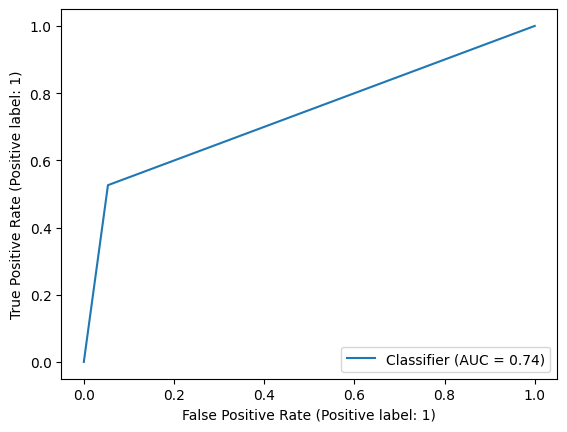

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_g)
plt.show()

## K-nearest Neighbors Classifier

In [ ]:
param_grid = {
    'n_neighbors': [5,7],
    'weights': ['distance']
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7], 'weights': ['distance']},
             scoring='roc_auc')

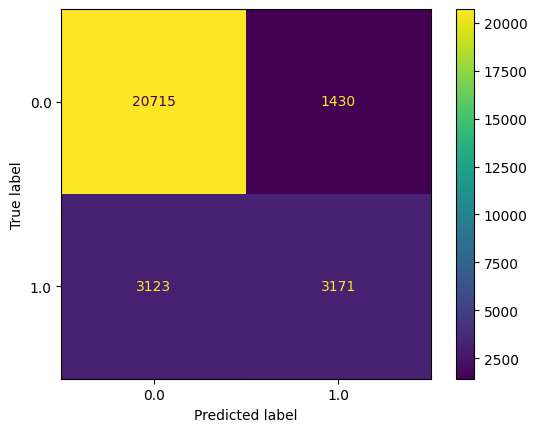

In [ ]:
Y_pred_KNN = grid.predict(X_test)
accuracy_KNN = accuracy_score(Y_test,Y_pred_KNN)
cm = confusion_matrix(Y_test,Y_pred_KNN)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_).plot()
plt.show()

In [ ]:
accuracy_KNN

0.8399029501740568

In [ ]:
#cross_val_score(KNN, X_train, Y_train, cv=5)

In [ ]:
roc_auc_score(Y_test, Y_pred_KNN)

0.7196193796799455

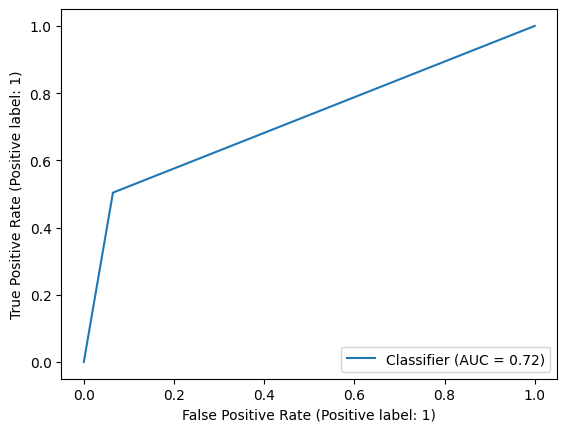

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_KNN)
plt.show()

## Logistic Regression Classifier

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
LR=LogisticRegression(max_iter = 1000)
LR_grid=GridSearchCV(LR,grid,cv=5, scoring='roc_auc')
LR_grid.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             scoring='roc_auc')

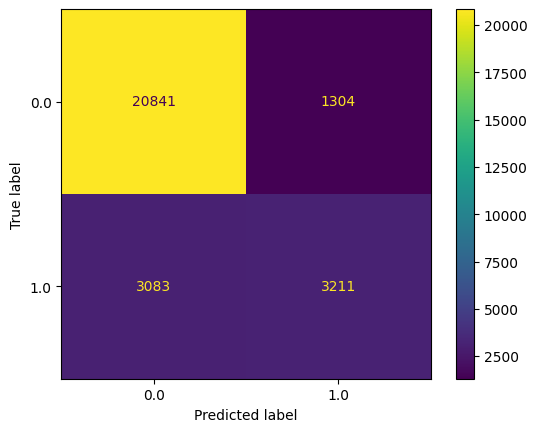

In [ ]:
Y_pred_lr = LR_grid.predict(X_test)
accuracy_lr = accuracy_score(Y_test,Y_pred_lr)
cm = confusion_matrix(Y_test,Y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_grid.classes_).plot()
plt.show()

In [ ]:
accuracy_lr

0.8457400049228173

In [ ]:
#cross_val_score(LR, X_train, Y_train, cv=5)

In [ ]:
roc_auc_score(Y_test, Y_pred_lr)

0.7256418951471234

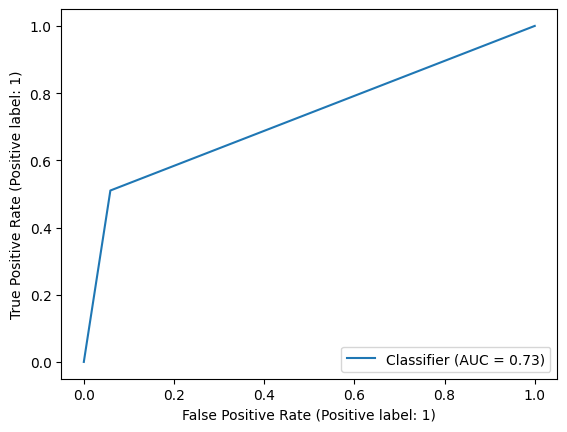

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_lr)
plt.show()

## Stochastic Gradient Descent Classifier

In [ ]:
SGD = SGDClassifier()

In [ ]:
sgdc_params = {
    'loss':['log_loss'],
    'penalty':['elasticnet'],
    'max_iter':[100],
    'alpha':np.logspace(-4, 4, 10),
    'l1_ratio':[0.05,0.09,0.1,0.2]
}
sgd_gs = GridSearchCV(SGD, sgdc_params,cv=5, scoring = 'roc_auc')
sgd_gs.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'l1_ratio': [0.05, 0.09, 0.1, 0.2],
                         'loss': ['log_loss'], 'max_iter': [100],
                         'penalty': ['elasticnet']},
             scoring='roc_auc')

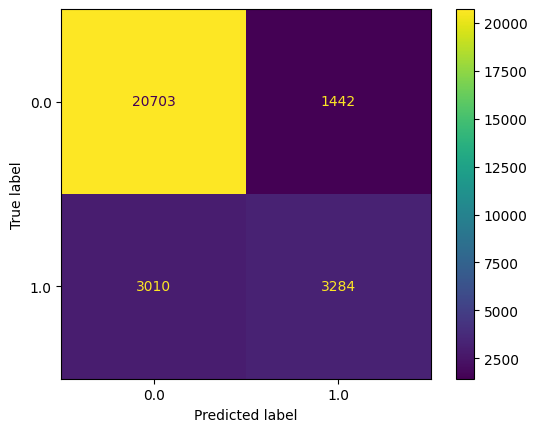

In [ ]:
Y_pred_sgd = sgd_gs.predict(X_test)
accuracy_sgd = accuracy_score(Y_test,Y_pred_sgd)
cm = confusion_matrix(Y_test,Y_pred_sgd)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sgd_gs.classes_).plot()
plt.show()

In [ ]:
accuracy_sgd

0.8434544111958929

In [ ]:
#cross_val_score(SGD, X_train, Y_train, cv=5)

In [ ]:
roc_auc_score(Y_test, Y_pred_sgd)

0.7283252414628918

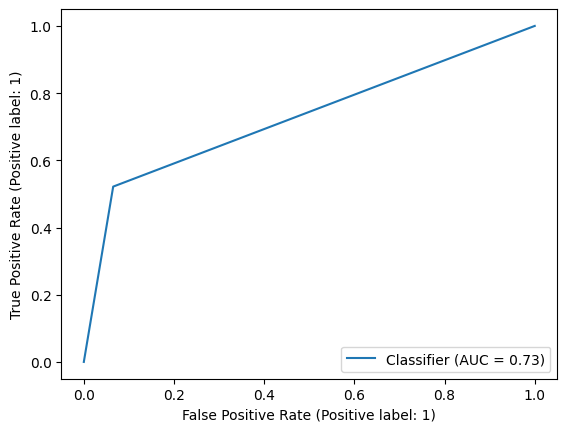

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_sgd)
plt.show()

## Model hybrydowy-głosowanie większościowe(twarde)


In [ ]:
model_clfs = EnsembleVoteClassifier(clfs = [CV_rf,gs_gb,LR_grid],voting = 'hard', weights = [1,1,1], fit_base_estimators = False).fit(X_train,Y_train)
Y_pred_clfs = model_clfs.predict(X_test)

/usr/local/lib/python3.10/dist-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


In [ ]:
accuracy_clfs = accuracy_score(Y_test,Y_pred_clfs)

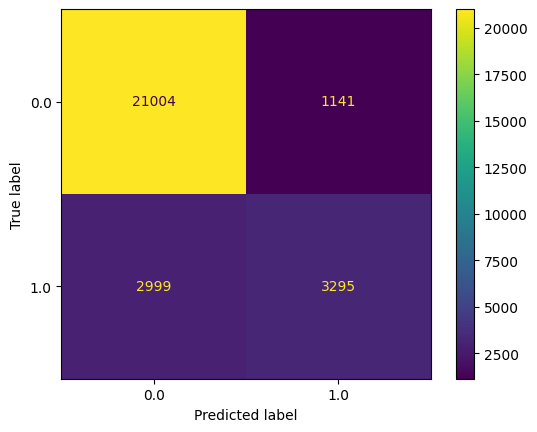

In [ ]:
cm = confusion_matrix(Y_test,Y_pred_clfs)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clfs.classes_).plot()
plt.show()

In [ ]:
accuracy_clfs

0.8544252610851296

In [ ]:
roc_auc_score(Y_test, Y_pred_clfs)

0.7359952060770568

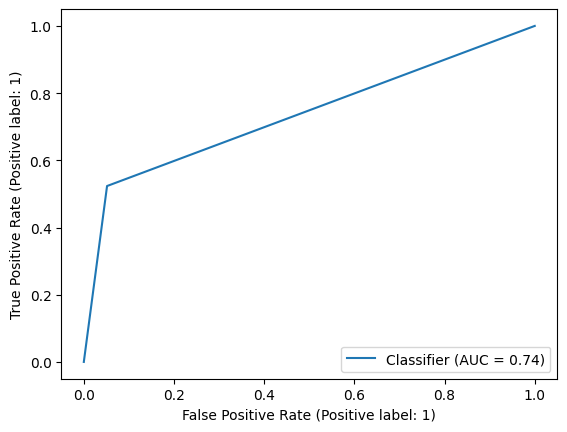

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_clfs)
plt.show()

## Model hybrydowy-głosowanie według najwyższego prawdopodobieństwa(głosowanie miękkie)

In [ ]:
model_clfs2 = EnsembleVoteClassifier(clfs = [CV_rf,gs_gb,sgd_gs],voting = 'soft', weights = [1,1,1], fit_base_estimators = False).fit(X_train,Y_train)
Y_pred_clfs2 = model_clfs2.predict(X_test)
accuracy_clfs2 = accuracy_score(Y_test,Y_pred_clfs2)

/usr/local/lib/python3.10/dist-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


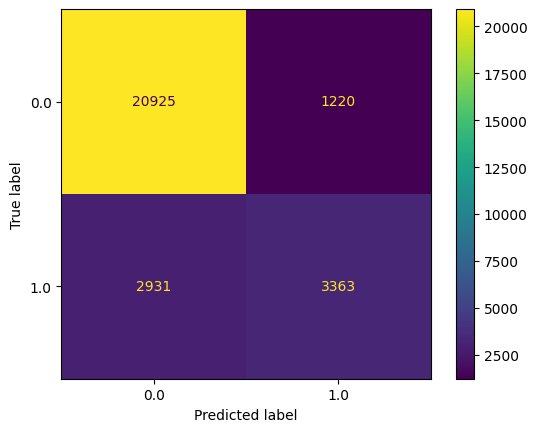

In [ ]:
cm = confusion_matrix(Y_test,Y_pred_clfs2)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clfs2.classes_).plot()
plt.show()

In [ ]:
accuracy_clfs2

0.8540384683005732

In [ ]:
roc_auc_score(Y_test, Y_pred_clfs2)

0.7396134778555672

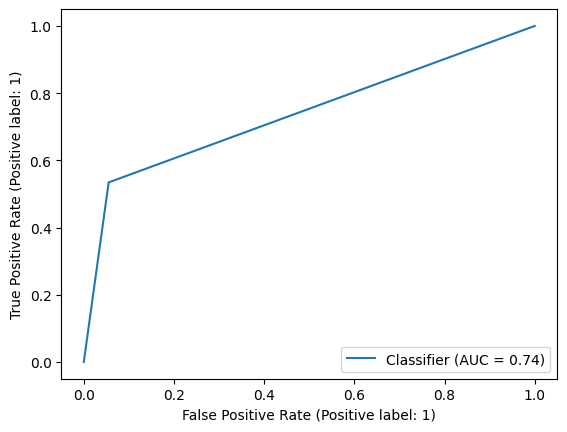

In [ ]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_clfs2)
plt.show()

In [ ]:
Z = X.head(1)
Z['MinTemp'] = 20
Z['MaxTemp'] = 27
Z['Rainfall'] = 100
Z['Evaporation'] = 50
Z['Sunshine'] = 6
Z['WindGustSpeed'] = 20
Z['WindSpeed9am'] = 10
Z['WindSpeed3pm'] = 15
Z['Humidity9am'] = 70
Z['Humidity3pm'] = 60
Z['Pressure9am'] = 1008
Z['Pressure3pm'] = 1005
Z['Cloud9am'] = 7
Z['Cloud3pm'] = 7
Z = pd.DataFrame(scaler.transform(Z))
Z['RainToday'] = 1
Z.columns =  X_train.columns
Z

<ipython-input-250-1eb92c4ca45f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['MinTemp'] = 20
<ipython-input-250-1eb92c4ca45f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['MaxTemp'] = 27
<ipython-input-250-1eb92c4ca45f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday
0,1.222996,0.530727,11.593002,14.055785,-0.594114,-1.521067,-0.452148,-0.41708,0.061071,0.414835,-1.430987,-1.535254,1.124991,1.186312,1


In [ ]:
model_clfs2.predict(Z)

array([1.])